In [33]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


# ***Imports***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import torchvision.transforms as transforms

from sklearn.preprocessing import LabelEncoder
from PIL import Image

import glob
import os


device = "cuda" if torch.cuda.is_available() else "cpu" 
print("Device available: ", device)

Device available:  cuda


# ***Reading Data Paths***

In [ ]:
base_dir = "/content/animal-faces/afhq/"
all_image_paths = glob.glob(os.path.join(base_dir, "*", "*", "*"))

image_paths = []
labels = []

for path in all_image_paths:
    parts = path.split(os.sep)
    if len(parts) >= 2:
        labels.append(parts[-2])
        image_paths.append(path)


df = pd.DataFrame({'image_paths': image_paths, 'labels': labels})
df.head()


,image_paths,labels
0,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
1,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
2,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
3,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
4,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog


In [36]:
print(df["labels"].value_counts())

labels
cat     5653
dog     5239
wild    5238
Name: count, dtype: int64


# ***Data Split***

In [37]:
train = df.sample(frac=0.7)
test = df.drop(train.index)
val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


# ***Preprocessing***

In [38]:
encoder = LabelEncoder()
encoder.fit(df["labels"])

LabelEncoder()

In [39]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

# ***Custom Dataset Class***

In [40]:
class CustomImages(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert("RGB")
    if self.transform:
      image = self.transform(image)
    return image, label

In [41]:
train_dataset = CustomImages(dataframe=train, transform=transform)
val_dataset = CustomImages(dataframe=val, transform=transform)
test_dataset = CustomImages(dataframe=test, transform=transform)

# ***Visualize Images***

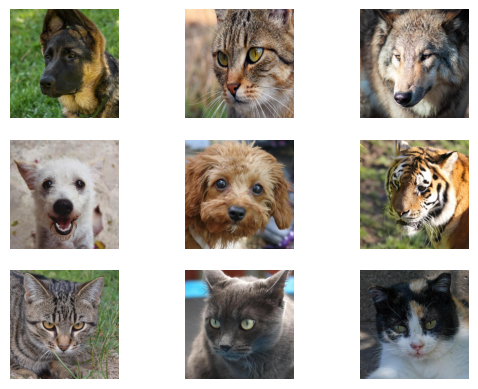

In [57]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

# ***Hyperparameters***

In [43]:
LR = 0.0001
Batch_size = 16
Epochs = 20

# ***DataLoaders***

In [44]:
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=True)

# ***CNNModel***

In [45]:
class CnnModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.2)

    self.flatten = nn.Flatten()

    self.linear = nn.Linear((256*16*16), 512)
    self.linear2 = nn.Linear(512, 128)

    self.output = nn.Linear(128, 3)

  def forward(self, x):

    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.conv4(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.flatten(x)

    x = self.linear(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = CnnModel().to(device)

# ***Model Summary***

In [46]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
              ReLU-3         [-1, 32, 128, 128]               0
           Dropout-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
         MaxPool2d-6           [-1, 64, 64, 64]               0
              ReLU-7           [-1, 64, 64, 64]               0
           Dropout-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
        MaxPool2d-10          [-1, 128, 32, 32]               0
             ReLU-11          [-1, 128, 32, 32]               0
          Dropout-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
        MaxPool2d-14          [-1, 256,

# ***Loss and Optimizer***

In [47]:
loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-5)

# ***Model Training***

In [48]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(Epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    output = model(inputs)
    train_loss = loss(output, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      val_loss = loss(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))

  print(f'''Epoch {epoch+1}/{Epochs}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*50)

Epoch 1/20, Train Loss: 5.2379 Train Accuracy 66.15
              Validation Loss: 0.8414 Validation Accuracy: 77.2727
Epoch 2/20, Train Loss: 2.5303 Train Accuracy 86.3697
              Validation Loss: 0.4447 Validation Accuracy: 88.719
Epoch 3/20, Train Loss: 1.7735 Train Accuracy 90.736
              Validation Loss: 0.3481 Validation Accuracy: 91.2397
Epoch 4/20, Train Loss: 1.3799 Train Accuracy 92.7376
              Validation Loss: 0.2721 Validation Accuracy: 93.719
Epoch 5/20, Train Loss: 1.1471 Train Accuracy 94.1546
              Validation Loss: 0.2608 Validation Accuracy: 94.4215
Epoch 6/20, Train Loss: 0.9574 Train Accuracy 95.1997
              Validation Loss: 0.2095 Validation Accuracy: 95.0826
Epoch 7/20, Train Loss: 0.8188 Train Accuracy 95.8551
              Validation Loss: 0.2458 Validation Accuracy: 94.4215
Epoch 8/20, Train Loss: 0.7101 Train Accuracy 96.4662
              Validation Loss: 0.1942 Validation Accuracy: 95.4959
Epoch 9/20, Train Loss: 0.6377 Train 

# ***Testing***

In [49]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    # Move inputs and labels to the correct device for testing
    inputs = inputs.to(device)
    labels = labels.to(device)

    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = loss(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.5275 and Loss is 0.0167


# ***Plotting The Training Processes***

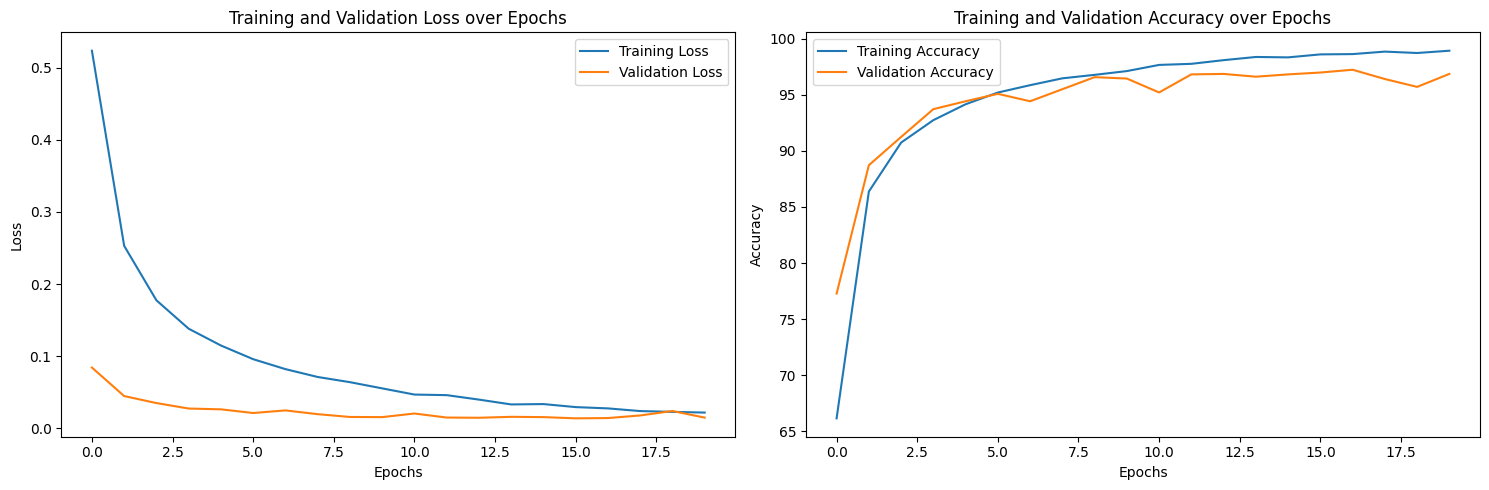

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

# ***Trying New Sample***

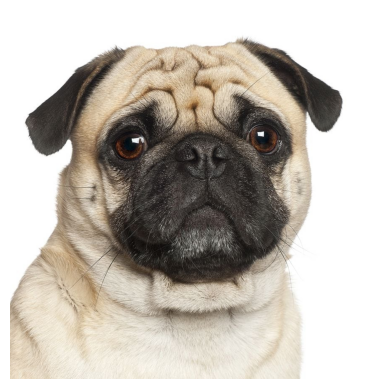

Prediction: ['dog']


In [67]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/Inspiration-for-Dog-Drawing.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

## Predict
print("Prediction:",predict_image("/content/Inspiration-for-Dog-Drawing.jpg"))